# Understanding Random Forests using Python (scikit-learn)
#### A Random Forest is a powerful machine learning algorithm that can be used for classification and regression, is interpretable, and doesn’t require feature scaling. Here’s how to apply it. 

[Decision trees](https://medium.com/data-science/understanding-decision-trees-for-classification-python-9663d683c952) are a popular supervised learning algorithm with benefits that include being able to be used for both regression and classification as well as being easy to interpret. However, decision trees aren’t the most performant algorithm and are prone to overfitting due to small variations in the training data. This can result in a completely different tree. This is why people often turn to ensemble models like Bagged Trees and Random Forests. These consist of multiple decision trees trained on bootstrapped data and aggregated to achieve better predictive performance than any single tree could offer. This tutorial includes the following:  
- What is Bagging
- What Makes Random Forests Different
- Training and Tuning a Random Forest using Scikit-Learn
- Calculating and Interpreting Feature Importance
- Visualizing Individual Decision Trees in a Random Forest


As always, the code used in this tutorial is available on my [GitHub](https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/CART/Random_Forest/RandomForestUsingPython.ipynb). A [video version](https://youtu.be/R9tJeEgHyeo) of this tutorial is also available on my YouTube channel for those who prefer to follow along visually. With that, let’s get started!

## What is Bagging (Bootstrap Aggregating)
![](../images/bagging.png)

Bagged trees and random forests can be further categorized as bagging algorithms (<b>b</b>ootstrap <b>agg</b>regat<b>ing</b>). Bagging consists of two steps:

1.) Bootstrap sampling: Create multiple training sets by randomly drawing samples with replacement from the original dataset. These new training sets, called bootstrapped datasets, typically contain the same number of rows as the original dataset, but individual rows may appear multiple times or not at all. On average, each bootstrapped dataset contains about 63.2% of the unique rows from the original data. The remaining ~36.8% of rows are left out and can be used for out-of-bag (OOB) evaluation. For more on this concept, see my [sampling with and without replacement blog post](https://towardsdatascience.com/understanding-sampling-with-and-without-replacement-python-7aff8f47ebe4/).

2.) Aggregating predictions: Each bootstrapped dataset is used to train a different decision tree model. The final prediction is made by combining the outputs of all individual trees. For classification, this is typically done through majority voting. For regression, predictions are averaged.

Training each tree on a different bootstrapped sample introduces variation across trees. While this doesn't fully eliminate correlation—especially when certain features dominate—it helps reduce overfitting when combined with aggregation. Averaging the predictions of many such trees reduces the overall variance of the ensemble, improving generalization.

### What Makes Random Forests Different
![](../images/BaggedVsRandomForests.png)

Suppose there’s a single strong feature in your dataset. In [bagged trees](https://youtu.be/urb2wRxnGz4?si=voTNstvcYQMLdlNJ), each tree may repeatedly split on that feature, leading to correlated trees and less benefit from aggregation. Random Forests reduce this issue by introducing further randomness. Specifically, they change how splits are selected during training:

1). Create N bootstrapped datasets. Note that while bootstrapping is commonly used in Random Forests, it is not strictly necessary because step 2 (random feature selection) introduces sufficient diversity among the trees.

2). For each tree, at each node, a random subset of features is selected as candidates, and the best split is chosen from that subset. In scikit-learn, this is controlled by the max_features parameter, which defaults to 'sqrt' for classifiers and 1 for regressors (equivalent to bagged trees).

3). Aggregating predictions: vote for classification and average for regression.

Note: Random Forests use [sampling with replacement (shown below) for bootstrapped datasets and sampling without replacement](https://towardsdatascience.com/understanding-sampling-with-and-without-replacement-python-7aff8f47ebe4/) for selecting a subset of features.

![](../images/TOCSampleWithReplacement.png)

### Out-of-Bag (OOB) Score

Because ~36.8% of training data is excluded from any given tree, you can use this holdout portion to evaluate that tree's predictions. Scikit-learn allows this via the oob_score=True parameter, providing an efficient way to estimate generalization error. You'll see this parameter used in the training example later in the tutorial.

## Training and Tuning a Random Forest in Scikit-Learn

Random Forests remain a strong baseline for tabular data thanks to their simplicity, interpretability, and ability to [parallelize](https://www.anyscale.com/blog/how-to-speed-up-scikit-learn-model-training) since each tree is trained independently. This section demonstrates how to load data, [perform a train test split](https://youtu.be/rCevxk3jeKs?si=SCzxap0-l3vBSrvM), train a baseline model, tune hyperparameters using grid search, and evaluate the final model on the test set.

### Step 1: Train a Baseline Model
Before tuning, it's good practice to train a baseline model using reasonable defaults. This gives you an initial sense of performance and lets you validate generalization using the out-of-bag (OOB) score, which is built into bagging-based models like Random Forests. This approach allows us to reserve the test set for final evaluation after tuning.

In [1]:
# Import libraries
# Some imports are only used later in the tutorial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree

# Load dataset
url = 'https://raw.githubusercontent.com/mGalarnyk/Tutorial_Data/master/King_County/kingCountyHouseData.csv'
df = pd.read_csv(url)

columns = ['bedrooms',
            'bathrooms',
            'sqft_living',
            'sqft_lot',
             'floors',
             'waterfront',
             'view',
             'condition',
             'grade',
             'sqft_above',
             'sqft_basement',
             'yr_built',
             'yr_renovated',
             'lat',
             'long',
             'sqft_living15',
             'sqft_lot15',
             'price']

df = df[columns]

In [2]:
# Define features and target
X = df.drop(columns='price')
y = df['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train baseline Random Forest
reg = RandomForestRegressor(
    n_estimators=100,        # number of trees
    max_features=1/3,        # fraction of features considered at each split
    oob_score=True,          # enables out-of-bag evaluation
    random_state=0
)

reg.fit(X_train, y_train)

# Evaluate baseline performance using OOB score
print(f"Baseline OOB score: {reg.oob_score_:.3f}")

Baseline OOB score: 0.861


### Step 2: Tune Hyperparameters with Grid Search
While the baseline model gives a strong starting point, performance can often be improved by tuning key hyperparameters. Grid search cross-validation, as implemented by GridSearchCV, systematically explores combinations of hyperparameters and uses cross-validation to evaluate each one, selecting the configuration with the highest validation performance.The most commonly tuned hyperparameters include:
- n_estimators: The number of decision trees in the forest. More trees can improve accuracy but increase training time.
- max_features: The number of features to consider when looking for the best split. Lower values reduce correlation between trees.
- max_depth: The maximum depth of each tree. Shallower trees are faster but may underfit.
- min_samples_split: The minimum number of samples required to split an internal node. Higher values can reduce overfitting.
- min_samples_leaf: The minimum number of samples required to be at a leaf node. Helps control tree size.
- bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used.

In [3]:
param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize model
rf = RandomForestRegressor(random_state=0, oob_score=True)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,             # 5-fold cross-validation
    scoring='r2',     # evaluation metric
    n_jobs=-1         # use all available CPU cores
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R^2 score: {grid_search.best_score_:.3f}")

Best parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best R^2 score: 0.862


### Step 3: Evaluate Final Model on Test Set
Now that we’ve selected the best-performing model based on cross-validation, we can evaluate it on the held-out test set to estimate its generalization performance.

In [4]:
# Evaluate final model on test set
best_model = grid_search.best_estimator_
print(f"Test R^2 score (final model): {best_model.score(X_test, y_test):.3f}")

Test R^2 score (final model): 0.889


## Calculating Random Forest Feature Importance
One of the key advantages of Random Forests is their interpretability — something that large language models (LLMs) often lack. While LLMs are powerful, they typically function as black boxes and can [exhibit biases that are difficult to identify](https://youtu.be/2v18R02mq8I?si=oeJadtZT3ytFmTE8). In contrast, scikit-learn supports two main methods for measuring feature importance in Random Forests: Mean Decrease in Impurity and Permutation Importance.

1). Mean Decrease in Impurity (MDI): Also known as Gini importance, this method calculates the total reduction in impurity brought by each feature across all trees. This is fast and built into the model via ```reg.feature_importances_```. However, impurity-based feature importances can be misleading, especially for features with high cardinality (many unique values), as these features are more likely to be chosen simply because they provide more potential split points.

In [5]:
importances = reg.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]
for i in sorted_idx:
    print(f"{feature_names[i]}: {importances[i]:.3f}")

sqft_living: 0.222
grade: 0.160
lat: 0.139
sqft_living15: 0.096
sqft_above: 0.091
long: 0.061
bathrooms: 0.047
yr_built: 0.038
view: 0.028
waterfront: 0.027
sqft_basement: 0.025
sqft_lot15: 0.021
sqft_lot: 0.020
bedrooms: 0.009
condition: 0.006
yr_renovated: 0.005
floors: 0.005


2). Permutation Importance: This method assesses the decrease in model performance when a single feature’s values are randomly shuffled. Unlike MDI, it accounts for feature interactions and correlation. It is more reliable but also more computationally expensive.

In [6]:
# Perform permutation importance on the test set
perm_importance = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=0)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
for i in sorted_idx:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.3f}")

lat: 0.270
sqft_living: 0.170
grade: 0.149
long: 0.117
sqft_living15: 0.054
sqft_above: 0.041
yr_built: 0.033
bathrooms: 0.016
view: 0.015
waterfront: 0.015
sqft_lot15: 0.007
sqft_lot: 0.007
sqft_basement: 0.003
condition: 0.002
bedrooms: 0.001
yr_renovated: 0.001
floors: 0.000


It is important to note that incorporating geographic features into your model can improve performance and realism. In our case, lat and long are useful as the plot below shows. It’s likely that companies like Zillow leverage location information extensively in their valuation models.

 ![](../images/KingCountyHousingPrices.png)

## Visualizing Individual Decision Trees in a Random Forest

A Random Forest consists of multiple decision trees—one for each estimator specified via the n_estimators parameter. After training the model, you can access these individual trees through the .estimators_ attribute. Visualizing a few of these trees can help illustrate how differently each one splits the data due to bootstrapped training samples and random feature selection at each split. While the earlier example used a RandomForestRegressor, here we demonstrate this visualization using a RandomForestClassifier trained on the Breast Cancer Wisconsin dataset to highlight Random Forests' versatility for both regression and classification tasks. [This short video](https://www.youtube.com/embed/X8UeOrsUKQ4) demonstrates what 100 trained estimators from this dataset look like.

### Fit a Random Forest Model using Scikit-Learn

In [7]:
# Load the Breast Cancer (Diagnostic) Dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Arrange Data into Features Matrix and Target Vector
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

# Random Forests in `scikit-learn` (with N = 100)
rf = RandomForestClassifier(n_estimators=100,
                            random_state=0)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

### Plotting Individual Estimators (decision trees) from a Random Forest using Matplotlib

You can now view all the individual trees from the fitted model.

In [8]:
rf.estimators_

[DecisionTreeClassifier(max_features='sqrt', random_state=209652396),
 DecisionTreeClassifier(max_features='sqrt', random_state=398764591),
 DecisionTreeClassifier(max_features='sqrt', random_state=924231285),
 DecisionTreeClassifier(max_features='sqrt', random_state=1478610112),
 DecisionTreeClassifier(max_features='sqrt', random_state=441365315),
 DecisionTreeClassifier(max_features='sqrt', random_state=1537364731),
 DecisionTreeClassifier(max_features='sqrt', random_state=192771779),
 DecisionTreeClassifier(max_features='sqrt', random_state=1491434855),
 DecisionTreeClassifier(max_features='sqrt', random_state=1819583497),
 DecisionTreeClassifier(max_features='sqrt', random_state=530702035),
 DecisionTreeClassifier(max_features='sqrt', random_state=626610453),
 DecisionTreeClassifier(max_features='sqrt', random_state=1650906866),
 DecisionTreeClassifier(max_features='sqrt', random_state=1879422756),
 DecisionTreeClassifier(max_features='sqrt', random_state=1277901399),
 DecisionTree

You can now visualize individual trees. The code below visualizes the first decision tree. It is important to note that individual decision trees in a Random Forest are typically grown deeper than standalone decision trees, leading to higher variance that is later reduced by aggregation.

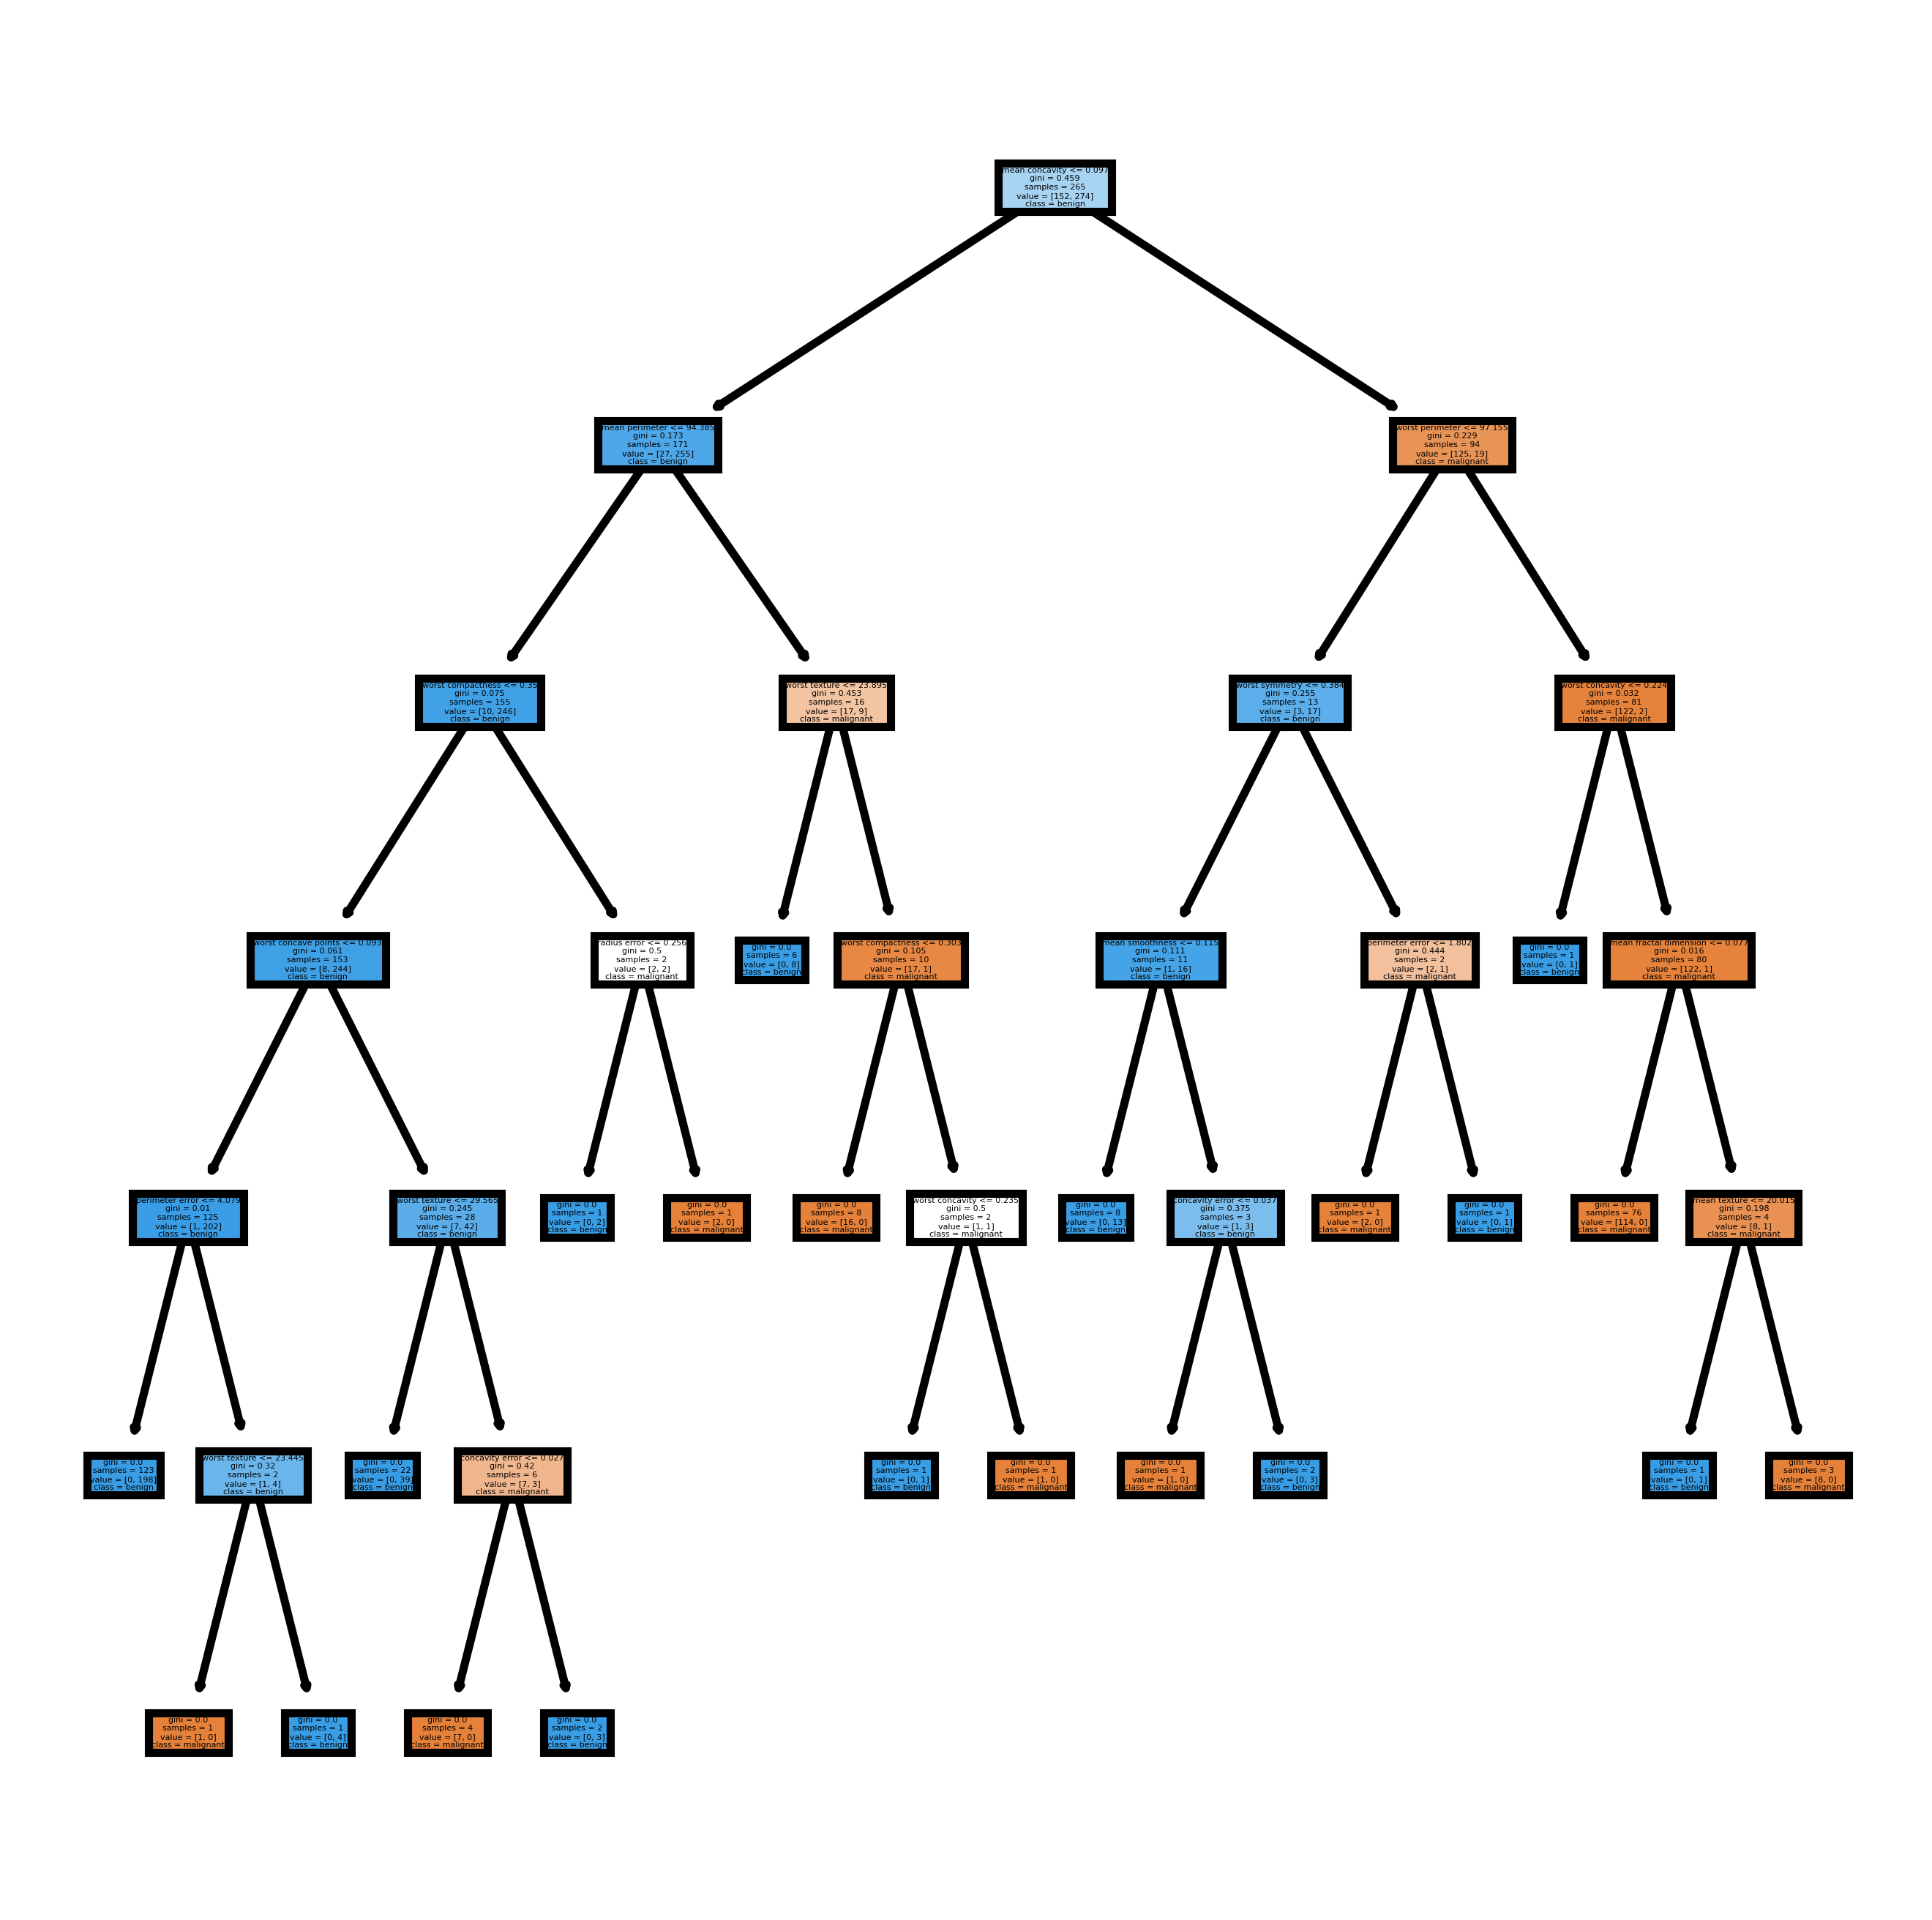

In [9]:
fn=data.feature_names
cn=data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

Although plotting many trees can be difficult to interpret, you may wish to explore the variety across estimators. The following example shows how to visualize the first five decision trees in the forest:

In [10]:
# This may not the best way to view each estimator as it is small
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2), dpi=3000)

for index in range(5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names=fn,
                   class_names=cn,
                   filled=True,
                   ax=axes[index])
    axes[index].set_title(f'Estimator: {index}', fontsize=11)

fig.savefig('rf_5trees.png')

## Conclusion
Random forests consist of multiple decision trees trained on bootstrapped data in order to achieve better predictive performance than could be obtained from any of the individual decision trees. If you have questions or thoughts on the tutorial, feel free to reach out through [YouTube](https://youtu.be/R9tJeEgHyeo) or [X](https://twitter.com/GalarnykMichael).